
=== EDA ===
Data shape: (27000, 3)
Label distribution:
 0    9000
1    9000
2    9000
Name: count, dtype: int64


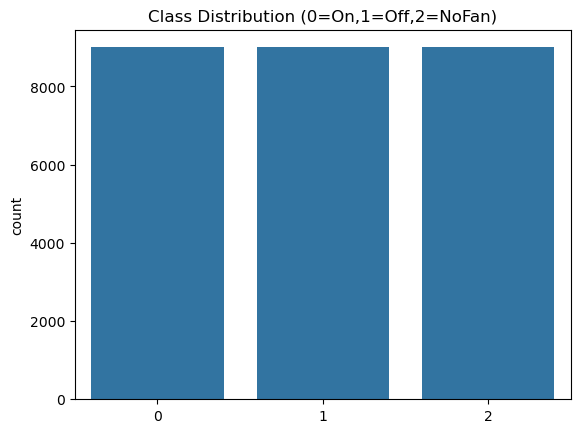

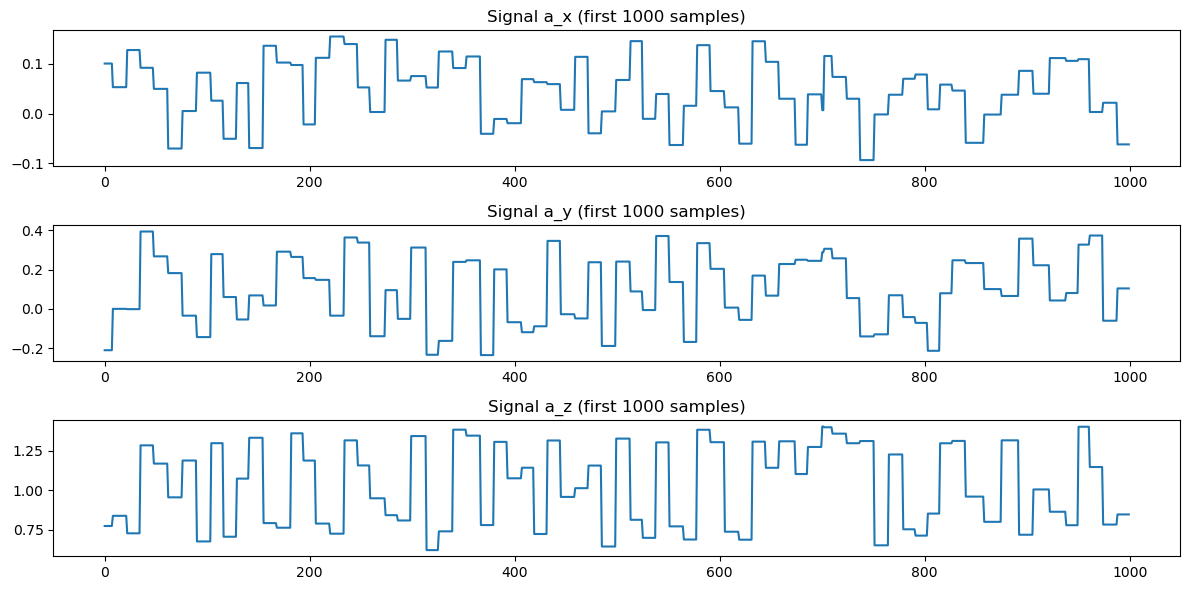

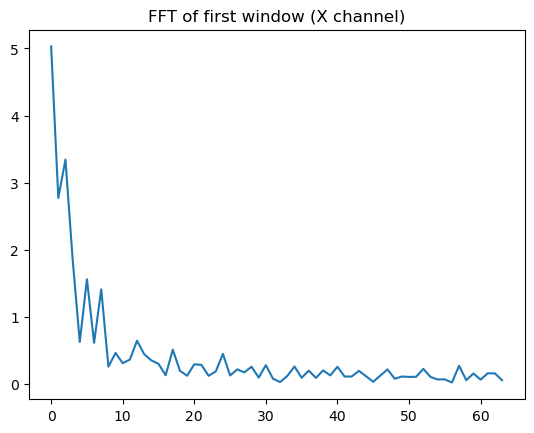

Windows shape: (420, 3, 128) Labels: (420,)
Training TEACHER...
Epoch 1/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.5494 - loss: 0.9728 - val_accuracy: 0.3333 - val_loss: 1.0969
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8464 - loss: 0.4743 - val_accuracy: 0.3333 - val_loss: 1.0970
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8780 - loss: 0.3654 - val_accuracy: 0.3452 - val_loss: 1.0943
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8905 - loss: 0.2877 - val_accuracy: 0.4643 - val_loss: 1.0929
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9074 - loss: 0.2418 - val_accuracy: 0.3810 - val_loss: 1.0935
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9044 - loss: 0.2083 - val_accuracy: 0.4286 - val_loss: 1.0936
Epoch 7/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9129 - loss: 0.1862 - val_accuracy: 0.4048 - val_loss: 1.0939
Epoch 8/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

=== Teacher Evaluation ===
              precision    recall  f1-score   support

           0       0.37      0.93      0.53        28
           1       0.50      0.25      0.33        28
           2       0.00      0.00      0.00        28

    accuracy                           0.39        84
   macro avg       0.29      0.39      0.29        84
weighted avg       0.29      0.39      0.29        84



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


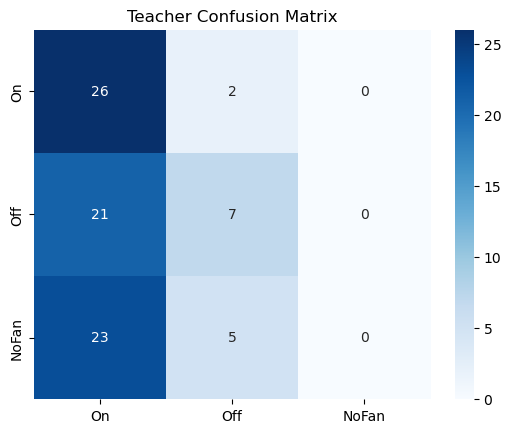

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


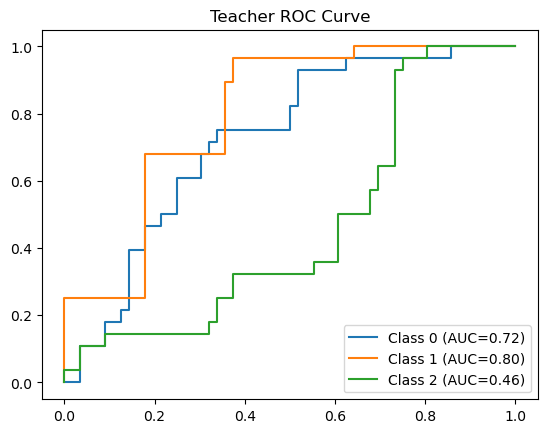

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


Epoch 1/30 val_acc=0.3333


2025-10-03 21:26:35.397133: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 2/30 val_acc=0.3333
Epoch 3/30 val_acc=0.3333
Epoch 4/30 val_acc=0.3333
Epoch 5/30 val_acc=0.3333
Epoch 6/30 val_acc=0.3333
Epoch 7/30 val_acc=0.3333
Epoch 8/30 val_acc=0.3333
Epoch 9/30 val_acc=0.3333
Epoch 10/30 val_acc=0.3333
Epoch 11/30 val_acc=0.3333
Epoch 12/30 val_acc=0.3333
Epoch 13/30 val_acc=0.3333
Epoch 14/30 val_acc=0.3333
Epoch 15/30 val_acc=0.3333
Epoch 16/30 val_acc=0.3333
Epoch 17/30 val_acc=0.3333
Epoch 18/30 val_acc=0.3333
Epoch 19/30 val_acc=0.3333
Epoch 20/30 val_acc=0.3333
Epoch 21/30 val_acc=0.3333
Epoch 22/30 val_acc=0.3333
Epoch 23/30 val_acc=0.3333
Epoch 24/30 val_acc=0.3333
Epoch 25/30 val_acc=0.3333
Epoch 26/30 val_acc=0.3333
Epoch 27/30 val_acc=0.3333
Epoch 28/30 val_acc=0.3333
Epoch 29/30 val_acc=0.3333


Epoch 30/30 val_acc=0.3333
Best Student Accuracy: 0.33333334
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

=== Student Evaluation ===
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.00      0.00      0.00        28
           2       0.33      1.00      0.50        28

    accuracy                           0.33        84
   macro avg       0.11      0.33      0.17        84
weighted avg       0.11      0.33      0.17        84



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


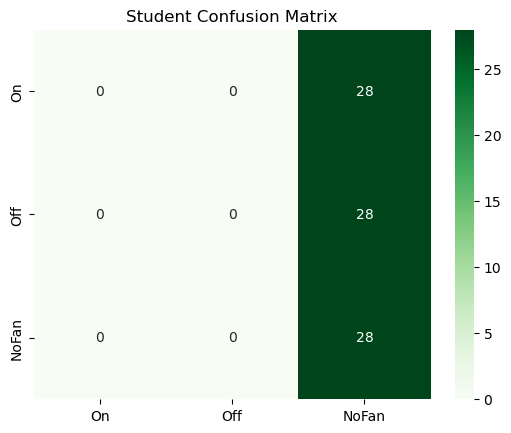

In [16]:
# esp32_pipeline_with_eda.py
# Full pipeline: EDA -> Teacher & Student training -> Quantization -> Export for ESP32C3
# Requirements: tensorflow>=2.9, numpy, pandas, sklearn, matplotlib, seaborn, scipy

import os, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from scipy.fft import fft
import subprocess

# ---------------- SETTINGS ----------------
WINDOW = 128
NUM_CHANNELS = 3
NUM_CLASSES = 3
BATCH = 64
EPOCHS_TEACHER = 30
EPOCHS_STUDENT = 30
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

# ---------------- LOAD DATA ----------------
def load_csvs():
    df_on  = pd.read_csv("motor_on_refined.csv")
    df_off = pd.read_csv("motor_off_refined.csv")
    df_nf  = pd.read_csv("motor_no_fan_refined.csv")

    df_on['class_label']  = 0
    df_off['class_label'] = 1
    df_nf['class_label']  = 2

    df = pd.concat([df_on, df_off, df_nf], axis=0, ignore_index=True)
    return df[['a_x','a_y','a_z']].values, df['class_label'].values, df

raw, lbl, df_all = load_csvs()

# ---------------- EDA ----------------
print("\n=== EDA ===")
print("Data shape:", raw.shape)
print("Label distribution:\n", pd.Series(lbl).value_counts())

# Plot class balance
sns.countplot(x=lbl)
plt.title("Class Distribution (0=On,1=Off,2=NoFan)")
plt.show()

# Plot sample signals
fig, axs = plt.subplots(3,1, figsize=(12,6))
for i,ch in enumerate(['a_x','a_y','a_z']):
    axs[i].plot(df_all[ch].values[:1000])
    axs[i].set_title(f"Signal {ch} (first 1000 samples)")
plt.tight_layout()
plt.show()

# FFT visualization of one window
sample = raw[:WINDOW,0]  # X channel
fft_vals = np.abs(fft(sample))
plt.plot(fft_vals[:WINDOW//2])
plt.title("FFT of first window (X channel)")
plt.show()

# ---------------- WINDOWING ----------------
def create_windows(data, labels, window=WINDOW, stride=WINDOW):
    X, y = [], []
    for i in range(0, len(data)-window, stride):
        X.append(data[i:i+window].T)   # (channels, window)
        y.append(labels[i+window-1])
    return np.array(X), np.array(y)

X, y = create_windows(raw, lbl, window=WINDOW, stride=WINDOW//2)
print("Windows shape:", X.shape, "Labels:", y.shape)

# split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=SEED)

# ---------------- TEACHER MODEL ----------------
def build_teacher(window=WINDOW, channels=NUM_CHANNELS, n_classes=NUM_CLASSES):
    inp = layers.Input(shape=(channels, window))
    x = layers.Permute((2,1))(inp)
    for filters, d in [(64,1),(128,2),(128,4)]:
        x = layers.Conv1D(filters, 3, dilation_rate=d, padding='same', activation='relu')(x)
        x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(128, activation='relu')(x)
    out = layers.Dense(n_classes, activation='softmax')(x)
    return Model(inp, out, name='teacher_big')

teacher = build_teacher()
teacher.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print("Training TEACHER...")
teacher.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=EPOCHS_TEACHER, batch_size=BATCH)
teacher.save("teacher_model.h5")

# ---------------- TEACHER EVALUATION ----------------
y_val_pred = np.argmax(teacher.predict(X_val), axis=1)
print("\n=== Teacher Evaluation ===")
print(classification_report(y_val, y_val_pred))
cm = confusion_matrix(y_val, y_val_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=['On','Off','NoFan'], yticklabels=['On','Off','NoFan'])
plt.title("Teacher Confusion Matrix")
plt.show()

# ROC Curve
y_val_bin = to_categorical(y_val, NUM_CLASSES)
y_val_prob = teacher.predict(X_val)
plt.figure()
for i in range(NUM_CLASSES):
    fpr, tpr, _ = roc_curve(y_val_bin[:,i], y_val_prob[:,i])
    plt.plot(fpr, tpr, label=f"Class {i} (AUC={auc(fpr,tpr):.2f})")
plt.legend()
plt.title("Teacher ROC Curve")
plt.show()

# ---------------- STUDENT MODEL ----------------
def build_student(window=WINDOW, channels=NUM_CHANNELS, n_classes=NUM_CLASSES):
    inp = layers.Input(shape=(channels, window))
    x = layers.Permute((2,1))(inp)
    x = layers.Conv1D(16, 3, padding='same', activation='relu')(x)
    for filters, k, d in [(16,3,1),(24,5,2),(32,3,4)]:
        x = layers.SeparableConv1D(filters, kernel_size=k, padding='same', dilation_rate=d, activation='relu')(x)
        x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(n_classes, activation='softmax')(x)
    return Model(inp, out, name='student_small')

student = build_student()

# ---------------- DISTILLATION ----------------
T = 4.0
alpha = 0.5
teacher.trainable = False

y_train_hard = to_categorical(y_train, NUM_CLASSES)
y_val_hard   = to_categorical(y_val, NUM_CLASSES)
y_train_soft = tf.nn.softmax(teacher.predict(X_train)/T).numpy()
y_val_soft   = tf.nn.softmax(teacher.predict(X_val)/T).numpy()

optimizer = tf.keras.optimizers.Adam(1e-3)
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train_hard, y_train_soft)).shuffle(2048).batch(BATCH)
val_dataset   = tf.data.Dataset.from_tensor_slices((X_val, y_val_hard, y_val_soft)).batch(BATCH)

best_val_acc = 0.0
for epoch in range(EPOCHS_STUDENT):
    for xb, yhard, ysoft in train_dataset:
        with tf.GradientTape() as tape:
            preds = student(xb, training=True)
            loss_hard = tf.keras.losses.categorical_crossentropy(yhard, preds)
            preds_soft = tf.nn.softmax(preds / T)
            loss_soft = tf.keras.losses.kullback_leibler_divergence(ysoft, preds_soft)
            loss = alpha*loss_hard + (1-alpha)*loss_soft
        grads = tape.gradient(loss, student.trainable_variables)
        optimizer.apply_gradients(zip(grads, student.trainable_variables))
    # val acc
    val_acc = tf.keras.metrics.CategoricalAccuracy()
    for xb, yhard, ysoft in val_dataset:
        preds = student(xb, training=False)
        val_acc.update_state(yhard, preds)
    val_acc_v = val_acc.result().numpy()
    print(f"Epoch {epoch+1}/{EPOCHS_STUDENT} val_acc={val_acc_v:.4f}")
    if val_acc_v > best_val_acc:
        best_val_acc = val_acc_v
        student.save("student_best.h5")

student = tf.keras.models.load_model("student_best.h5")
print("Best Student Accuracy:", best_val_acc)

# ---------------- STUDENT EVALUATION ----------------
y_val_pred_st = np.argmax(student.predict(X_val), axis=1)
print("\n=== Student Evaluation ===")
print(classification_report(y_val, y_val_pred_st))
cm = confusion_matrix(y_val, y_val_pred_st)
sns.heatmap(cm, annot=True, fmt='d', cmap="Greens", xticklabels=['On','Off','NoFan'], yticklabels=['On','Off','NoFan'])
plt.title("Student Confusion Matrix")
plt.show()